# Inverse distance weighting - Synthetic Dataset (SR1)

https://photutils.readthedocs.io/en/stable/api/photutils.utils.ShepardIDWInterpolator.html

https://pareekshithkatti.medium.com/inverse-distance-weighting-interpolation-in-python-68351fb612d2

## Importing packages and loading necessary datasets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipdw
from sklearn.model_selection import train_test_split, GridSearchCV, GroupKFold
from photutils.utils import ShepardIDWInterpolator
import time
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

# 800 points calibration

In [2]:
import os

# Get the current working directory
current_dir = os.getcwd()

# Get the parent directory
parent_dir = os.path.dirname(current_dir)

# Change to the parent directory
os.chdir(parent_dir)

# Print the new current working directory to confirm
print("Changed to:", os.getcwd())

Changed to: C:\Users\chloe\OneDrive\AY2024 FYP\FYP-Code\FYP-Spatial-Analytics


In [3]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/SR1/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_SR1_input_randomfield_cal800.csv')
val_df = pd.read_csv(f'{file_path}val_SR1_input_randomfield_cal800.csv')
test_df = pd.read_csv(f'{file_path}test_SR1_input_randomfield_cal800.csv')

In [4]:
# Initialize an empty dictionary for storing scores
cv_score_list_800_power = {}
powers_list = [1, 2, 3, 4, 5, 6, 7, 8]

start_time = time.time()

# For each hyperparameter value
for power in powers_list:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    idw_model = ShepardIDWInterpolator(combined_array_train, cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = idw_model.__call__(combined_array_validation, power=power)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_800_power[power] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_800_power))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in  cv_score_list_800_power.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in power {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in power {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")


,1,2,3,4,5,6,7,8
Validation Score MAE,0.497045,0.501072,0.519071,0.536062,0.549383,0.559573,0.567466,0.573593
Validation Score RMSE,0.625276,0.632041,0.655479,0.678073,0.696064,0.709982,0.720796,0.729289
Validation Score MAPE,4.540271,4.729186,4.915811,5.102883,5.245948,5.339095,5.408548,5.463288
Validation Score R Squared,0.679672,0.672703,0.647979,0.623293,0.603037,0.587003,0.574326,0.564236


The smallest Validation Score MAE is 0.4970449226273791, found in power 1.
The smallest Validation Score RMSE is 0.6252757625457899, found in power 1.
The smallest Validation Score MAPE is 4.540271129714469, found in power 1.
The largest Validation Score R Squared is 0.6796719954284807, found in power 1.
Validation Computation Time: 0.52 seconds


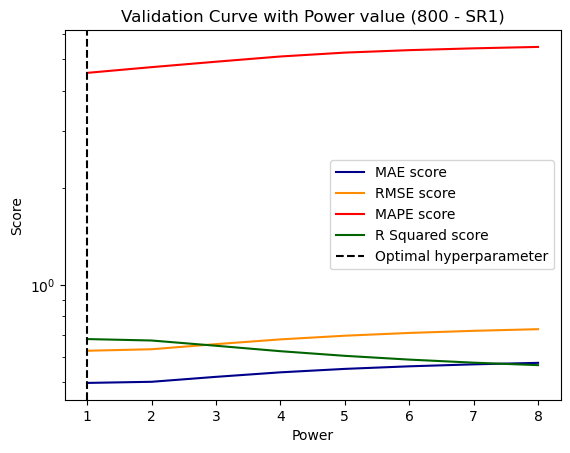

In [27]:
power = 1
df = pd.DataFrame(cv_score_list_800_power).T
plt.plot(powers_list, df["Validation Score MAE"], color='darkblue', label='MAE score')
plt.plot(powers_list, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
plt.plot(powers_list, df["Validation Score MAPE"], color='red', label='MAPE score')
plt.plot(powers_list, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
plt.axvline(power, c='k', ls='--', label = "Optimal hyperparameter")

plt.xlabel('Power')
plt.ylabel('Score')
plt.yscale('log')
plt.legend()
plt.title("Validation Curve with Power value (800 - SR1)")
plt.show()

In [6]:
# Initialize an empty dictionary for storing scores
cv_score_list_800_n = {}
n_neighbors_list = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]

start_time = time.time()

# For each number of neighbors
for n_neighbors in n_neighbors_list:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    idw_model = ShepardIDWInterpolator(combined_array_train, cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = idw_model.__call__(combined_array_validation, power=3, n_neighbors=n_neighbors)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_800_n[n_neighbors] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_800_n))

# Identifying the best number of neighbors based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in cv_score_list_800_n.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in n_neighbors {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in n_neighbors {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")


,2,4,6,8,10,12,14,16,18,20
Validation Score MAE,0.563982,0.534813,0.524263,0.519071,0.515364,0.514031,0.513413,0.513056,0.512564,0.512134
Validation Score RMSE,0.717544,0.676039,0.661707,0.655479,0.651528,0.649599,0.648694,0.647931,0.647171,0.646538
Validation Score MAPE,5.667477,5.025128,4.885621,4.915811,4.794145,4.825448,4.819697,4.765512,4.717912,4.676703
Validation Score R Squared,0.578159,0.625549,0.641258,0.647979,0.652210,0.654266,0.655228,0.656039,0.656845,0.657516


The smallest Validation Score MAE is 0.512134421636431, found in n_neighbors 20.
The smallest Validation Score RMSE is 0.6465383551439251, found in n_neighbors 20.
The smallest Validation Score MAPE is 4.6767031261328595, found in n_neighbors 20.
The largest Validation Score R Squared is 0.6575159840850748, found in n_neighbors 20.
Validation Computation Time: 0.59 seconds


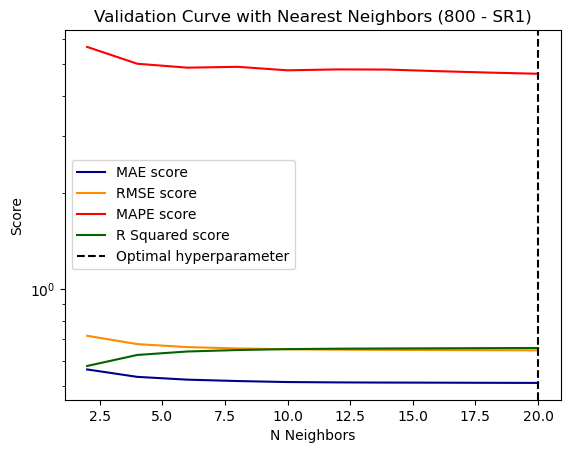

In [26]:
n_neighbors = 20
df = pd.DataFrame(cv_score_list_800_n).T
plt.plot(n_neighbors_list, df["Validation Score MAE"], color='darkblue', label='MAE score')
plt.plot(n_neighbors_list, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
plt.plot(n_neighbors_list, df["Validation Score MAPE"], color='red', label='MAPE score')
plt.plot(n_neighbors_list, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
plt.axvline(n_neighbors, c='k', ls='--', label = "Optimal hyperparameter")

plt.xlabel('N Neighbors')
plt.ylabel('Score')
plt.yscale('log')
plt.legend()
plt.title("Validation Curve with Nearest Neighbors (800 - SR1)")
plt.show()

# 1000 points calibration

In [8]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/SR1/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_SR1_input_randomfield_cal1000.csv')
val_df = pd.read_csv(f'{file_path}val_SR1_input_randomfield_cal1000.csv')
test_df = pd.read_csv(f'{file_path}test_SR1_input_randomfield_cal1000.csv')

In [9]:
# Initialize an empty dictionary for storing scores
cv_score_list_1000_power = {}
powers_list = [1, 2, 3, 4, 5, 6, 7, 8]

start_time = time.time()

# For each hyperparameter value
for power in powers_list:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    idw_model = ShepardIDWInterpolator(combined_array_train, cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = idw_model.__call__(combined_array_validation, power=power)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_1000_power[power] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_1000_power))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in cv_score_list_1000_power.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in power {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in power {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")


,1,2,3,4,5,6,7,8
Validation Score MAE,0.477542,0.484295,0.505427,0.525101,0.540311,0.551772,0.560335,0.566793
Validation Score RMSE,0.601736,0.612902,0.640328,0.666192,0.686441,0.701755,0.713303,0.722053
Validation Score MAPE,3.790188,3.917001,3.973050,3.935016,3.846159,4.139517,4.352745,4.504134
Validation Score R Squared,0.703337,0.692225,0.664064,0.636378,0.613937,0.596519,0.583131,0.572840


The smallest Validation Score MAE is 0.47754163343884576, found in power 1.
The smallest Validation Score RMSE is 0.6017359833393602, found in power 1.
The smallest Validation Score MAPE is 3.7901875072149105, found in power 1.
The largest Validation Score R Squared is 0.703336794668429, found in power 1.
Validation Computation Time: 0.46 seconds


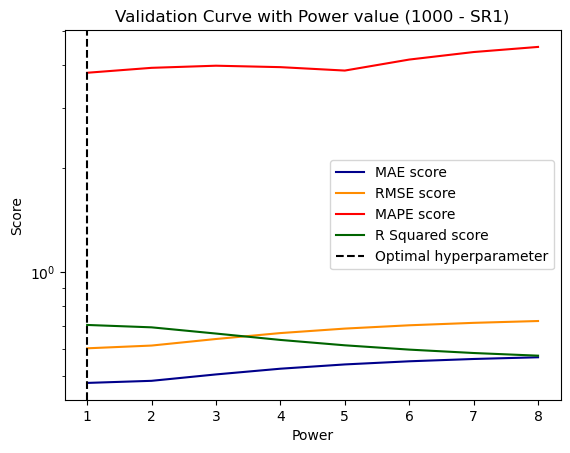

In [25]:
power = 1
df = pd.DataFrame(cv_score_list_1000_power).T
plt.plot(powers_list, df["Validation Score MAE"], color='darkblue', label='MAE score')
plt.plot(powers_list, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
plt.plot(powers_list, df["Validation Score MAPE"], color='red', label='MAPE score')
plt.plot(powers_list, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
plt.axvline(power, c='k', ls='--', label = "Optimal hyperparameter")

plt.xlabel('Power')
plt.ylabel('Score')
plt.yscale('log')
plt.legend()
plt.title("Validation Curve with Power value (1000 - SR1)")
plt.show()

In [11]:
# Initialize an empty dictionary for storing scores
cv_score_list_1000_n = {}
n_neighbors_list = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]

start_time = time.time()

# For each number of neighbors
for n_neighbors in n_neighbors_list:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    idw_model = ShepardIDWInterpolator(combined_array_train, cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = idw_model.__call__(combined_array_validation, power=3, n_neighbors=n_neighbors)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_1000_n[n_neighbors] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_1000_n))  # Transposed for better readability

# Identifying the best number of neighbors based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in cv_score_list_1000_n.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in n_neighbors {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in n_neighbors {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")


,2,4,6,8,10,12,14,16,18,20
Validation Score MAE,0.552161,0.523329,0.509913,0.505427,0.502317,0.499645,0.498324,0.498006,0.497791,0.497423
Validation Score RMSE,0.704075,0.661550,0.645954,0.640328,0.636662,0.633645,0.632134,0.631333,0.630814,0.630468
Validation Score MAPE,3.941923,3.924946,3.930936,3.973050,4.015758,4.055076,3.957665,4.011486,4.029719,4.064351
Validation Score R Squared,0.593847,0.641427,0.658135,0.664064,0.667900,0.671039,0.672606,0.673436,0.673972,0.674330


The smallest Validation Score MAE is 0.4974226914726591, found in n_neighbors 20.
The smallest Validation Score RMSE is 0.6304680082276689, found in n_neighbors 20.
The smallest Validation Score MAPE is 3.9249463891128165, found in n_neighbors 4.
The largest Validation Score R Squared is 0.6743299449726584, found in n_neighbors 20.
Validation Computation Time: 0.51 seconds


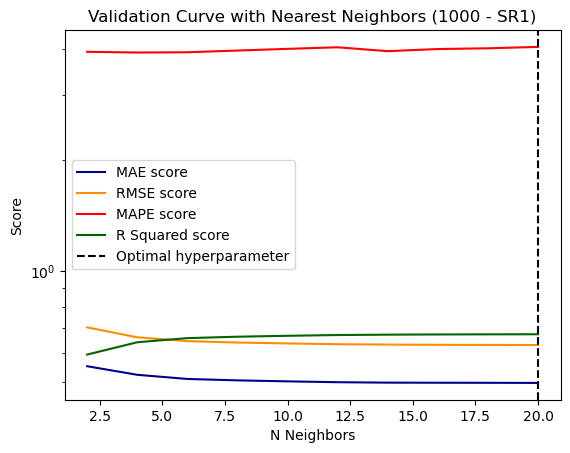

In [24]:
n_neighbors = 20
df = pd.DataFrame(cv_score_list_1000_n).T
plt.plot(n_neighbors_list, df["Validation Score MAE"], color='darkblue', label='MAE score')
plt.plot(n_neighbors_list, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
plt.plot(n_neighbors_list, df["Validation Score MAPE"], color='red', label='MAPE score')
plt.plot(n_neighbors_list, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
plt.axvline(n_neighbors, c='k', ls='--', label = "Optimal hyperparameter")

plt.xlabel('N Neighbors')
plt.ylabel('Score')
plt.yscale('log')
plt.legend()
plt.title("Validation Curve with Nearest Neighbors (1000 - SR1)")
plt.show()

# 1500 points calibration

In [13]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/SR1/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_SR1_input_randomfield_cal1500.csv')
val_df = pd.read_csv(f'{file_path}val_SR1_input_randomfield_cal1500.csv')
test_df = pd.read_csv(f'{file_path}test_SR1_input_randomfield_cal1500.csv')

In [14]:
# Initialize an empty dictionary for storing scores
cv_score_list_1500_power = {}
powers_list = [1, 2, 3, 4, 5, 6, 7, 8]

start_time = time.time()

# For each hyperparameter value
for power in powers_list:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    idw_model = ShepardIDWInterpolator(combined_array_train, cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = idw_model.__call__(combined_array_validation, power=power)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_1500_power[power] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_1500_power))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in cv_score_list_1500_power.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in power {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in power {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")


,1,2,3,4,5,6,7,8
Validation Score MAE,0.463667,0.474348,0.495780,0.515736,0.530406,0.541433,0.549614,0.555658
Validation Score RMSE,0.583496,0.597348,0.624270,0.649579,0.669013,0.683382,0.694035,0.701992
Validation Score MAPE,3.819406,4.072090,4.283623,4.380827,4.418076,4.414396,4.390718,4.360540
Validation Score R Squared,0.721049,0.707648,0.680702,0.654287,0.633292,0.617371,0.605347,0.596246


The smallest Validation Score MAE is 0.46366729727604084, found in power 1.
The smallest Validation Score RMSE is 0.5834960694741129, found in power 1.
The smallest Validation Score MAPE is 3.81940611848786, found in power 1.
The largest Validation Score R Squared is 0.721049214200461, found in power 1.
Validation Computation Time: 0.44 seconds


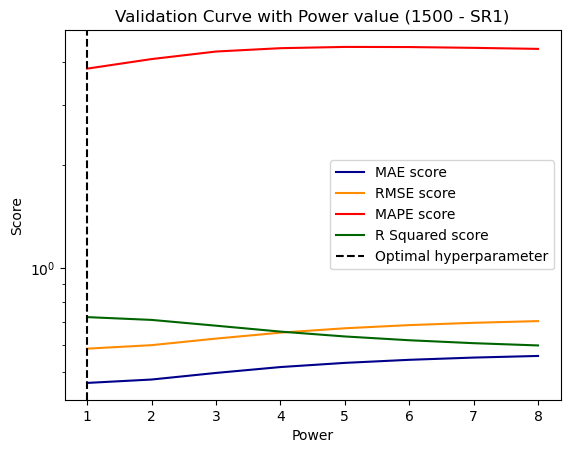

In [23]:
power = 1
df = pd.DataFrame(cv_score_list_1500_power).T
plt.plot(powers_list, df["Validation Score MAE"], color='darkblue', label='MAE score')
plt.plot(powers_list, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
plt.plot(powers_list, df["Validation Score MAPE"], color='red', label='MAPE score')
plt.plot(powers_list, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
plt.axvline(power, c='k', ls='--', label = "Optimal hyperparameter")

plt.xlabel('Power')
plt.ylabel('Score')
plt.yscale('log')
plt.legend()
plt.title("Validation Curve with Power value (1500 - SR1)")
plt.show()

In [16]:
# Initialize an empty dictionary for storing scores
cv_score_list_1500_n = {}
n_neighbors_list = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]

start_time = time.time()

# For each number of neighbors
for n_neighbors in n_neighbors_list:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    idw_model = ShepardIDWInterpolator(combined_array_train, cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = idw_model.__call__(combined_array_validation, power=3, n_neighbors=n_neighbors)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_1500_n[n_neighbors] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_1500_n))  # Transposed for better readability

# Identifying the best number of neighbors based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in cv_score_list_1500_n.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in n_neighbors {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in n_neighbors {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")


,2,4,6,8,10,12,14,16,18,20
Validation Score MAE,0.541235,0.514646,0.500920,0.495780,0.492331,0.490016,0.488401,0.487719,0.486776,0.486133
Validation Score RMSE,0.683363,0.647126,0.631166,0.624270,0.620246,0.617576,0.615629,0.614767,0.613647,0.612885
Validation Score MAPE,4.203184,4.415734,4.333134,4.283623,4.203909,4.103728,4.105965,4.022174,4.045334,3.999929
Validation Score R Squared,0.617391,0.656893,0.673608,0.680702,0.684805,0.687512,0.689480,0.690349,0.691476,0.692242


The smallest Validation Score MAE is 0.48613267571779395, found in n_neighbors 20.
The smallest Validation Score RMSE is 0.6128849449993492, found in n_neighbors 20.
The smallest Validation Score MAPE is 3.9999288916427695, found in n_neighbors 20.
The largest Validation Score R Squared is 0.6922418050246275, found in n_neighbors 20.
Validation Computation Time: 0.65 seconds


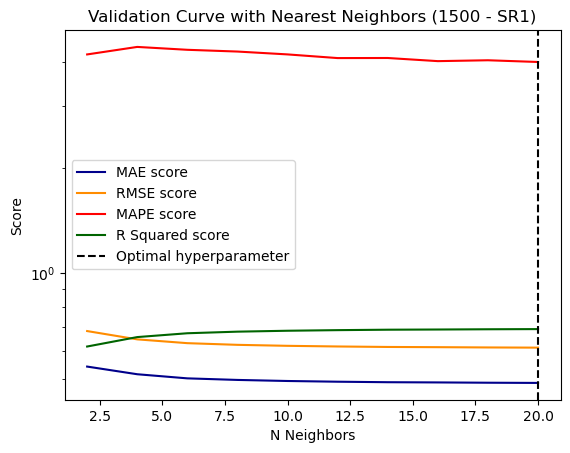

In [22]:
n_neighbors = 20
df = pd.DataFrame(cv_score_list_1500_n).T
plt.plot(n_neighbors_list, df["Validation Score MAE"], color='darkblue', label='MAE score')
plt.plot(n_neighbors_list, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
plt.plot(n_neighbors_list, df["Validation Score MAPE"], color='red', label='MAPE score')
plt.plot(n_neighbors_list, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
plt.axvline(n_neighbors, c='k', ls='--', label = "Optimal hyperparameter")

plt.xlabel('N Neighbors')
plt.ylabel('Score')
plt.yscale('log')
plt.legend()
plt.title("Validation Curve with Nearest Neighbors (1500 - SR1)")
plt.show()

# 2000 points calibration

In [18]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/SR1/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_SR1_input_randomfield_cal2000.csv')
val_df = pd.read_csv(f'{file_path}val_SR1_input_randomfield_cal2000.csv')
test_df = pd.read_csv(f'{file_path}test_SR1_input_randomfield_cal2000.csv')

In [19]:
# Initialize an empty dictionary for storing scores
cv_score_list_2000_power = {}
powers_list = [1, 2, 3, 4, 5, 6, 7, 8]

start_time = time.time()

# For each hyperparameter value
for power in powers_list:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    idw_model = ShepardIDWInterpolator(combined_array_train, cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = idw_model.__call__(combined_array_validation, power=power)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_2000_power[power] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_2000_power))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in cv_score_list_2000_power.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in power {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in power {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")


,1,2,3,4,5,6,7,8
Validation Score MAE,0.446230,0.457201,0.476724,0.495604,0.510766,0.522514,0.531315,0.537929
Validation Score RMSE,0.564336,0.576580,0.600809,0.624974,0.644025,0.658073,0.668357,0.675933
Validation Score MAPE,2.855731,3.130784,3.775028,4.131097,4.326583,4.426143,4.479956,4.511165
Validation Score R Squared,0.739068,0.727623,0.704250,0.679981,0.660174,0.645186,0.634010,0.625666


The smallest Validation Score MAE is 0.4462304277036879, found in power 1.
The smallest Validation Score RMSE is 0.5643360261767926, found in power 1.
The smallest Validation Score MAPE is 2.855730682143914, found in power 1.
The largest Validation Score R Squared is 0.7390680434481982, found in power 1.
Validation Computation Time: 0.57 seconds


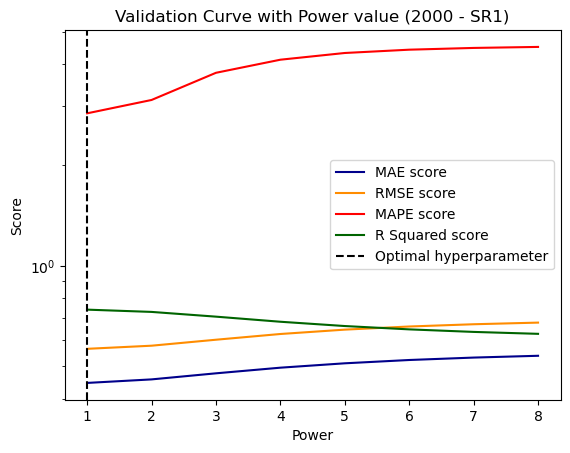

In [21]:
power = 1
df = pd.DataFrame(cv_score_list_2000_power).T
plt.plot(powers_list, df["Validation Score MAE"], color='darkblue', label='MAE score')
plt.plot(powers_list, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
plt.plot(powers_list, df["Validation Score MAPE"], color='red', label='MAPE score')
plt.plot(powers_list, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
plt.axvline(power, c='k', ls='--', label = "Optimal hyperparameter")

plt.xlabel('Power')
plt.ylabel('Score')
plt.yscale('log')
plt.legend()
plt.title("Validation Curve with Power value (2000 - SR1)")
plt.show()

In [28]:
# Initialize an empty dictionary for storing scores
cv_score_list_2000_n = {}
n_neighbors_list = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]

start_time = time.time()

# For each number of neighbors
for n_neighbors in n_neighbors_list:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    idw_model = ShepardIDWInterpolator(combined_array_train, cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = idw_model.__call__(combined_array_validation, power=3, n_neighbors=n_neighbors)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_2000_n[n_neighbors] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_2000_n))  # Transposed for better readability

# Identifying the best number of neighbors based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in cv_score_list_2000_n.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in n_neighbors {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in n_neighbors {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")


,2,4,6,8,10,12,14,16,18,20
Validation Score MAE,0.522903,0.493024,0.481367,0.476724,0.473929,0.471988,0.470630,0.469558,0.468822,0.468445
Validation Score RMSE,0.655591,0.621509,0.607746,0.600809,0.596791,0.594331,0.592627,0.591440,0.590612,0.590238
Validation Score MAPE,4.329575,4.021152,3.843769,3.775028,3.725898,3.678981,3.642660,3.634493,3.603600,3.582736
Validation Score R Squared,0.647859,0.683520,0.697381,0.704250,0.708192,0.710593,0.712251,0.713402,0.714204,0.714566


The smallest Validation Score MAE is 0.4684447726312685, found in n_neighbors 20.
The smallest Validation Score RMSE is 0.5902379307682554, found in n_neighbors 20.
The smallest Validation Score MAPE is 3.582735933981257, found in n_neighbors 20.
The largest Validation Score R Squared is 0.7145658380703234, found in n_neighbors 20.
Validation Computation Time: 0.57 seconds


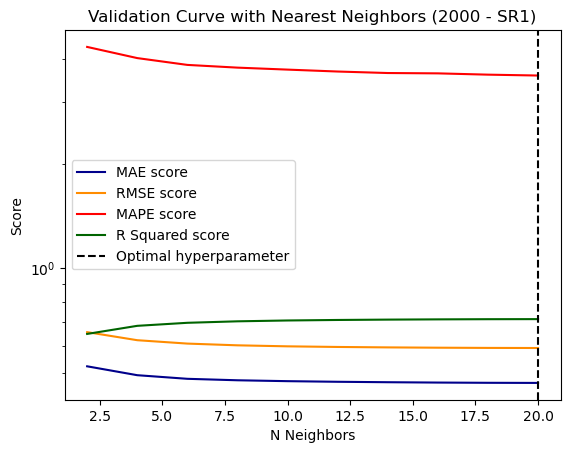

In [29]:
n_neighbors = 20
df = pd.DataFrame(cv_score_list_2000_n).T
plt.plot(n_neighbors_list, df["Validation Score MAE"], color='darkblue', label='MAE score')
plt.plot(n_neighbors_list, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
plt.plot(n_neighbors_list, df["Validation Score MAPE"], color='red', label='MAPE score')
plt.plot(n_neighbors_list, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
plt.axvline(n_neighbors, c='k', ls='--', label = "Optimal hyperparameter")

plt.xlabel('N Neighbors')
plt.ylabel('Score')
plt.yscale('log')
plt.legend()
plt.title("Validation Curve with Nearest Neighbors (2000 - SR1)")
plt.show()

## Validation score as calibration set size increases

In [40]:
def calculate_means(data_structures):
    all_means = {}
    for structure_id, data in enumerate(data_structures, 1):
        means = {key: sum(d[key] for d in data.values()) / len(data) for key in data[next(iter(data))]}
        all_means[f"Structure {structure_id}"] = means
    return all_means

# List of data structures
data_structures_n = [cv_score_list_800_n,cv_score_list_1000_n,cv_score_list_1500_n, cv_score_list_2000_n]
data_structures_power = [cv_score_list_800_power,cv_score_list_1000_power,cv_score_list_1500_power, cv_score_list_2000_power]

# Calculate means
all_means_n = calculate_means(data_structures_n)
all_means_power = calculate_means(data_structures_power)

In [41]:
new_keys = [800, 1000, 1500, 2000]

# Function to replace keys
def replace_keys(structures, new_keys):
    # Make sure there are enough new keys for the structures
    if len(new_keys) < len(structures):
        raise ValueError("Not enough new keys for the number of structures")

    # New dictionary to store replaced key structures
    replaced_structures = {}

    # Use zip to iterate over both the items in structures and the new_keys simultaneously
    for new_key, (old_key, value) in zip(new_keys, structures.items()):
        replaced_structures[new_key] = value

    return replaced_structures

all_means_n = replace_keys(all_means_n, new_keys)
all_means_power = replace_keys(all_means_power, new_keys)

In [42]:
cal_size = [800,1000,1500,2000]
all_means_power_df = pd.DataFrame(all_means_power).T
all_means_n_df = pd.DataFrame(all_means_n).T
all_means_n_df

,Validation Score MAE,Validation Score RMSE,Validation Score MAPE,Validation Score R Squared
800,0.522269,0.660223,4.909345,0.642505
1000,0.508434,0.644696,3.990491,0.659076
1500,0.498396,0.628068,4.171671,0.676446
2000,0.479739,0.604169,3.783789,0.700622


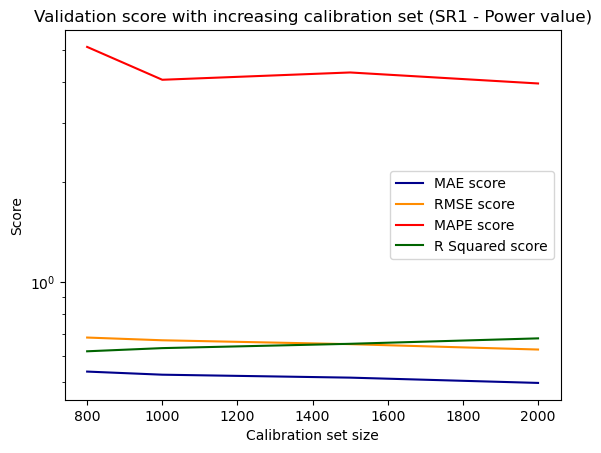

In [43]:
plt.plot(cal_size, all_means_power_df["Validation Score MAE"], color='darkblue', label='MAE score')
plt.plot(cal_size, all_means_power_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
plt.plot(cal_size, all_means_power_df["Validation Score MAPE"], color='red', label='MAPE score')
plt.plot(cal_size, all_means_power_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')

plt.xlabel('Calibration set size')
plt.ylabel('Score')
plt.yscale('log')
plt.legend()
plt.title("Validation score with increasing calibration set (SR1 - Power value)")
plt.show()

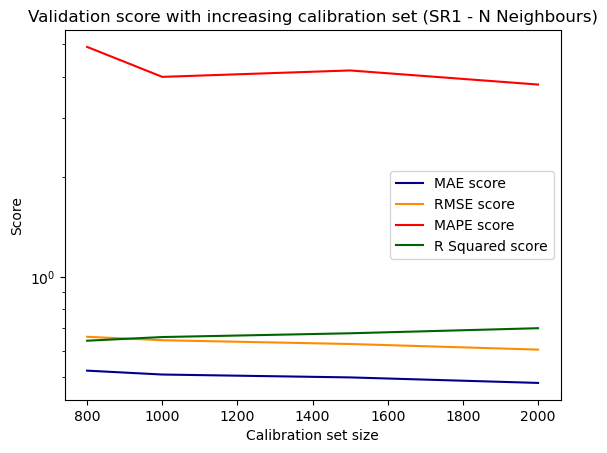

In [44]:
plt.plot(cal_size, all_means_n_df["Validation Score MAE"], color='darkblue', label='MAE score')
plt.plot(cal_size, all_means_n_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
plt.plot(cal_size, all_means_n_df["Validation Score MAPE"], color='red', label='MAPE score')
plt.plot(cal_size, all_means_n_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')

plt.xlabel('Calibration set size')
plt.ylabel('Score')
plt.yscale('log')
plt.legend()
plt.title("Validation score with increasing calibration set (SR1 - N Neighbours)")
plt.show()

## Testing model (Final Performance Metrics)

In [46]:
filenames = ['SR1_input_randomfield_cal800', 'SR1_input_randomfield_cal1000', 'SR1_input_randomfield_cal1500', 'SR1_input_randomfield_cal2000']
#cal_SR0_input_randomfield_cal2000.csv
combined_df = pd.DataFrame()
for file in filenames:
    cal_df = pd.read_csv(f'Synthetic Data/SR1/cal_{file}.csv')
    combined_df = pd.concat([cal_df, combined_df], ignore_index=True)

combined_df = pd.concat([val_df, combined_df], ignore_index=True)
combined_df = combined_df.drop_duplicates() #The calibration sets are subsets of one another, hence needed

combined_df #All caliration points and validation data points

,x,y,z
0,39,4,-1.774013
1,47,42,-0.393699
2,92,88,-0.462323
3,24,43,0.601361
4,37,92,-0.129720
...,...,...,...
3995,93,12,-3.037629
3996,56,25,0.688154
3997,22,8,-0.676579
3998,38,35,-0.744753


In [47]:
eval_combined_array_coordinates = np.array([list(pair) for pair in zip(combined_df['x'], combined_df['y'])])

start_time = time.time()

idw_model = ShepardIDWInterpolator(eval_combined_array_coordinates, combined_df['z'])

 # Predict at test locations
eval_combined_array_test = np.array([list(pair) for pair in zip(test_df['x'], test_df['y'])])
z_pred_test = idw_model.__call__(eval_combined_array_test, power = 6, n_neighbors = 6)

rmse = np.sqrt(mean_squared_error(test_df['z'], z_pred_test))
mae = mean_absolute_error(test_df['z'], z_pred_test)
mape = mean_absolute_percentage_error(test_df['z'], z_pred_test)
r2 = r2_score(test_df['z'], z_pred_test)

end_time = time.time()

print("MAE:", mae)
print("RMSE:", rmse)
print("MAPE:", mape)
print("R Squared:", r2)
print(f"Testing Computation Time: {end_time - start_time:.2f} seconds")

MAE: 0.5032411995812556
RMSE: 0.6294476305815263
MAPE: 2.2580694631882863
R Squared: 0.6845408013572568
Testing Computation Time: 0.07 seconds


### Plotting Spatial Interpolation of entire area with Model

In [50]:
filenames = ['cal_SR1_input_randomfield_cal800', 'cal_SR1_input_randomfield_cal1000', 'cal_SR1_input_randomfield_cal1500', 'cal_SR1_input_randomfield_cal2000',
            'val_SR1_input_randomfield_cal2000', 'test_SR1_input_randomfield_cal2000']
#cal_SR0_input_randomfield_cal2000.csv
all_df = pd.DataFrame()
for file in filenames:
    df = pd.read_csv(f'Synthetic Data/SR1/{file}.csv')
    all_df = pd.concat([df, all_df], ignore_index=True)

all_df = all_df.drop_duplicates() #The calibration sets are subsets of one another, hence needed

all_df #All calbration, validation and test data points

,x,y,z
0,83,56,-1.154367
1,40,74,-0.398708
2,90,28,-0.161047
3,51,84,-1.042425
4,32,48,-1.328360
...,...,...,...
5995,93,12,-3.037629
5996,56,25,0.688154
5997,22,8,-0.676579
5998,38,35,-0.744753


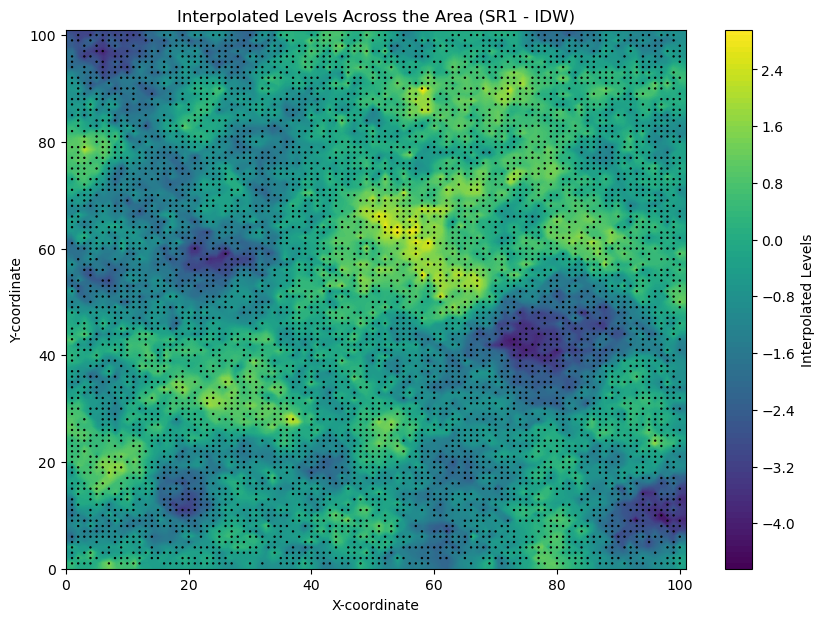

Spatial Interpolation Computation Time: 0.29 seconds


In [51]:
# Using full set: Convert columns to numpy arrays
observed_location_columns = ['x', 'y']
observed_values_column = 'z'
observed_locations = all_df[observed_location_columns].values
observed_values = all_df[observed_values_column].values

# Initialize IDW model
idw_model = ShepardIDWInterpolator(observed_locations, observed_values)

# Start timing spatial interpolation
start_time_interpolation = time.time()

x_min, x_max = observed_locations[:, 0].min() - 1, observed_locations[:, 0].max() + 1
y_min, y_max = observed_locations[:, 1].min() - 1, observed_locations[:, 1].max() + 1
x_range = np.linspace(x_min, x_max, 100)
y_range = np.linspace(y_min, y_max, 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)
grid_points = np.c_[x_grid.ravel(), y_grid.ravel()]

# Interpolate values
interpolated_values = idw_model.__call__(grid_points, power = 3, n_neighbors = 4)
z_grid = interpolated_values.reshape(x_grid.shape)

end_time_interpolation = time.time()  # End timing spatial interpolation

# Visualization
plt.figure(figsize=(10, 7))
plt.contourf(x_grid, y_grid, z_grid, cmap='viridis', levels=100)
plt.colorbar(label='Interpolated Levels')
plt.scatter(all_df['x'], all_df['y'], c=all_df['z'], cmap='viridis', edgecolor='k', label='Observed', s= 0.5)
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
#plt.legend()
plt.title('Interpolated Levels Across the Area (SR1 - IDW)')
plt.show()

print(f"Spatial Interpolation Computation Time: {end_time_interpolation - start_time_interpolation:.2f} seconds")